In [1]:
import glob, pandas, uproot, matplotlib, re, math
import numpy as np
from gap_statistic import OptimalK
from plotParams import varLabels, binnings, units
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

randomState = 5
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
font = {'size':14}
matplotlib.rc('font', **font)

In [2]:
#sigPath='/data/atlasfs02/a/users/whopkins/SheffieldNtuples_v21.2.71-SRABC-PostFAR-Signals/'
sigPath='/data/atlasfs02/a/users/whopkins/stopSignals/'
sigPaths = glob.glob(sigPath+'*TT_directTT*10724*p3712*')
bkgPaths = glob.glob('/data/atlasfs02/a/users/whopkins/SheffieldNtuples_SRABC/*10724*.root')
treeName='NominalFixed'

# Only select variables that were used in the original signal regions.
from stop0L import selections
srList = ['SRATT', 'SRATW', 'SRAT0', 'SRBTT', 'SRBTW', 'SRBT0']#, 'SRC1_5']
splitPat = '[><=]'
allCuts = []
for sr in srList:
    allCuts.extend([re.split(splitPat, cut.replace('(', '').replace(')', ''))[0].rstrip().lstrip() for cut in selections[sr].split("*")])
branches = sorted(list(set(allCuts)))
branches.append('pT_1jet')
branches.append('LumiWeight')
branches.append('AnalysisWeight')

#print(branches) 
allSampLabels = []
for path in sigPaths:
    fName = path.split('/')[-1]
    
    firstSplitStr = 'directTT_';
    secondSplitStr = '.'
    if 'bWN' in fName:
        firstSplitStr = 'bWN_';
        secondSplitStr = '_Mad'
    allSampLabels.append('sig_'+fName.split(firstSplitStr)[1].split(secondSplitStr)[0])

#print('All available variables')

dataList = []
lumi = 139000
# This is needed due to memory constraints, I think...
nSigEvents = 1000
sigData = {}
nSigs = 80
chosenPaths = sigPaths[:nSigs]
minNEvents = 100
sampLabels = []
for path, sampName in zip(sigPaths, allSampLabels):
    if '27_' in sampName or '77_' in sampName or '62_' in sampName or '12_' in sampName:
        continue
    stopMass, lspMass = [int(mass) for mass in sampName.split('_')[1:3]]
    # We want an evenly spaced grid. But of course I don't have all samples.
    # Our signal grid is not evenly generated. This causes artificial overdensities
    # when clustering. Let's keep it simple and only select signals in one theory
    # parameter dimension: the LSP mass. 
    if (lspMass != 400) or (stopMass % 100 != 0 or lspMass % 100 != 0):
        continue
    tree = uproot.open(path)[treeName]
    data = tree.arrays(branches, library='pd')
    if 'pT_1jet' not in sorted(tree.keys()):
        continue
    data['weight'] = data['AnalysisWeight']*data['LumiWeight']*lumi
    if data.shape[0] < minNEvents or data.weight.sum() < 1E-4:
        print(sampName, 'had few events.')
        continue
    data['sampName'] = sampName
    if data.shape[0] < nSigEvents:
        sigData[sampName] = data
    else:
        sigData[sampName] = data.sample(n=nSigEvents)
    sampLabels.append(sampName)

bkgData = []
weights = []
for path in bkgPaths:
    fName = path.split('/')[-1]
    sampName = fName.split('.')[2]
    inF = uproot.open(path)
    tree = inF[treeName]
    if 'pT_1jet' not in sorted(tree.keys()):
        continue
    data = tree.arrays(branches, library='pd')
    data['weight'] = data['AnalysisWeight']*data['LumiWeight']*lumi
    data['sampName'] = 'bkg'
    bkgData.append(data)
dataList = list(sigData.values())
dataList.extend(bkgData)

allSamps = pandas.concat(dataList)
sampLabels.append('bkg')
print(sorted(sampLabels))

['bkg', 'sig_1000_400', 'sig_1100_400', 'sig_1200_400', 'sig_1300_400', 'sig_1400_400', 'sig_600_400', 'sig_700_400', 'sig_800_400', 'sig_900_400']


In [3]:
rawDataPresel = allSamps[(allSamps['nbaselineLep']==0)].copy()
sampSizes = {}
sampYields = {}
print(len(set(sampLabels)))

for sampName in pandas.unique(rawDataPresel.sampName):
    sampIndex = rawDataPresel['sampName']==sampName
    sampYield = rawDataPresel[sampIndex].weight.sum()
    if sampYield == 0:
        print("Dropping", sampName)
        rawDataPresel.drop(sampIndex)
    sampSizes[sampName] = rawDataPresel[sampIndex].shape[0]
    sampYields[sampName] = sampYield
    
maxYieldKey = max(sampYields, key=lambda k: sampYields[k])
tempDFs = []
goodSamps = pandas.unique(rawDataPresel.sampName)
for sampName in sampYields:
    sampIndex = rawDataPresel['sampName']==sampName
    rawDataPresel.loc[sampIndex, 'clus_weight'] = rawDataPresel.loc[sampIndex, 'weight']*(sampYields[maxYieldKey]/sampYields[sampName])
    #print(rawDataPresel[sampIndex].clus_weight.sum())

10


In [4]:
vetoList=['passMETtriggers', 'passtauveto', 'nbaselineLep', 'eT_miss', 
          'flav_1fatjet_kt12', 'flav_2fatjet_kt12', 'num_bjets', 'NbV', 'NjV', 'nj_good']
trainBranches = [branch for branch in branches if branch not in vetoList]
print(trainBranches)
# Tried adding more variables but this seems to cause a degradation in performance: only one signal cluster is found.
# (two are expected based on the manually designed signal regions).
trainBranches = ['dRb1b2', 'metsigST']#, 'm_1fatjet_kt12', 'm_2fatjet_kt12']#, 'MTbmin', 'MTbmax', 'm_1fatjet_kt8']#, 'pT_1jet']
varListStr = '_'.join(trainBranches)
print(varListStr)
prettySampNames = {
    'bkg':'SM Background',
}
for sampNum, sampName in enumerate(sampLabels):
    if 'sig' in sampName:
        stopMass, lspMass = sampName.split('_')[1:3]
        #prettySampNames[samp] = '$m_{\\tilde{t}}, m_{\\chi}$='+stopMass+', '+lspMass+' GeV'
        prettySampNames[sampName] = f'SUSY model {sampNum+1}' 

['MT2Chi2', 'MTbmax', 'MTbmin', 'dRb1b2', 'dphimin4', 'm_1fatjet_kt12', 'm_1fatjet_kt8', 'm_2fatjet_kt12', 'metsigST', 'pT_2jet', 'pT_4jet', 'pT_1jet', 'LumiWeight', 'AnalysisWeight']
dRb1b2_metsigST


In [5]:
scaledData = rawDataPresel.copy(deep=True)
scalers = {}
for column in trainBranches:
    print(column)
    scalers[column] = MinMaxScaler()
    scaledData[[column]] = scalers[column].fit_transform(scaledData[[column]])
clusteringData = scaledData[trainBranches]

dRb1b2
metsigST


In [6]:
def clusterer(X: np.ndarray, k: int, weights: np.ndarray, random_state: int):
    """
    Function to wrap a sklearn model as a clusterer for OptimalK
    First two arguments are always the data matrix, and k. 
    Third argument are sample weights so that we can weight background correctly.
    """
    m = KMeans(random_state=random_state)
    m.fit(X, sample_weight=weights)
    return m.cluster_centers_, m.predict(X, sample_weight=weights)

k_max=20
optimalK = OptimalK(n_jobs=30, clusterer=clusterer, clusterer_kwargs={"random_state":randomState, 'weights':rawDataPresel.clus_weight})
n_clusters = optimalK(clusteringData.to_numpy(), cluster_array=np.arange(1, k_max+1))

3


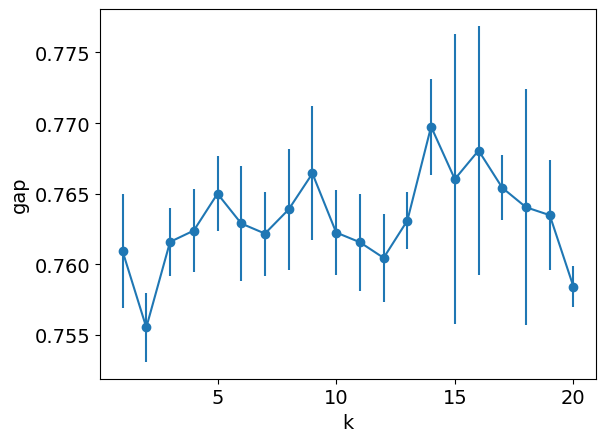

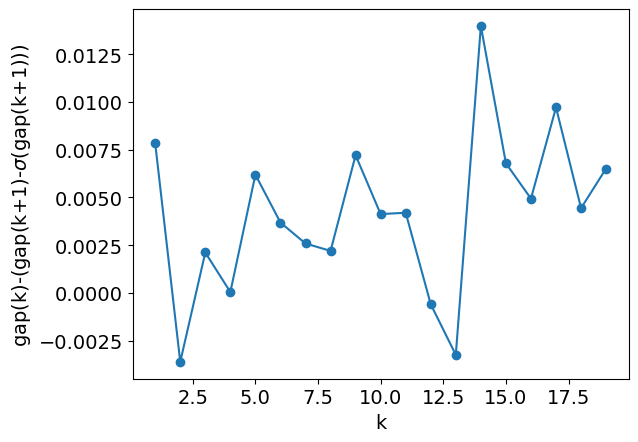

In [7]:
fig, ax = plt.subplots()
plt.errorbar(range(1, k_max+1), optimalK.gap_df['gap_value'], yerr=optimalK.gap_df['sk'], fmt='-o')
plt.ylabel('gap')
plt.xlabel('k')
plt.savefig(f"gap_new_{varListStr}.svg",bbox_inches='tight')
plt.savefig(f"gap_new_{varListStr}.pdf",bbox_inches='tight')
fig, ax = plt.subplots()
plt.plot(range(1, k_max+1), optimalK.gap_df['diff'], '-o')
plt.ylabel('gap(k)-(gap(k+1)-$\sigma$(gap(k+1)))')
plt.xlabel('k')
plt.savefig(f"diff_{varListStr}.svg",bbox_inches='tight')
plt.savefig(f"diff_{varListStr}.pdf",bbox_inches='tight')
# Get the best k which is the first k for which gap(k)-(gap(k+1)-sigma(k+1))>=0
bestK = -1;
for diffI in range(optimalK.gap_df['diff'].shape[0]):
    if optimalK.gap_df['diff'][diffI] > 0 and diffI+1 > 1:
        bestK = diffI+1;
        break;
print(bestK)

14


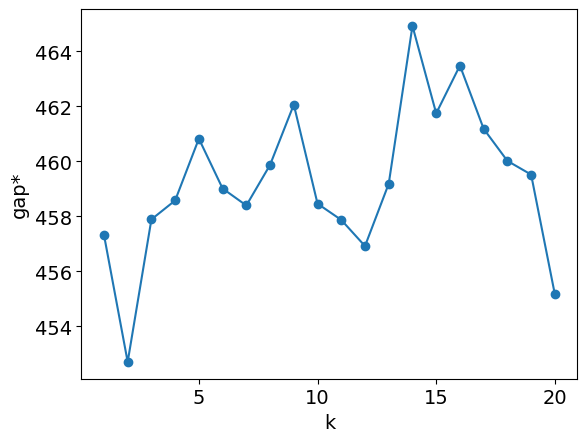

In [8]:
fig, ax = plt.subplots()
plt.errorbar(range(1, k_max+1), optimalK.gap_df['gap*'], fmt='-o')
plt.ylabel('gap*')
plt.xlabel('k')
plt.savefig(f"gapstar_{varListStr}.svg",bbox_inches='tight')
plt.savefig(f"gapstar_{varListStr}.pdf",bbox_inches='tight')

# Get the best k which is the first k for which gap(k)-(gap(k+1)-sigma(k+1))>=0
bestKStar = np.argmax(optimalK.gap_df['gap*'])+1
print(bestKStar)
# The gap statistics overestimates the number of clusters when there are many clusters.
# if bestK >=5:
#     bestK = bestKStar

In [9]:
# Now get the cluster labels for the raw data
bestNClus = bestK
Kmean = KMeans(n_clusters=bestNClus, random_state=randomState)
#Kmean.fit(clusteringData)
Kmean.fit(clusteringData[trainBranches], sample_weight=rawDataPresel.clus_weight)
centroids = Kmean.cluster_centers_
clusLabels = Kmean.labels_

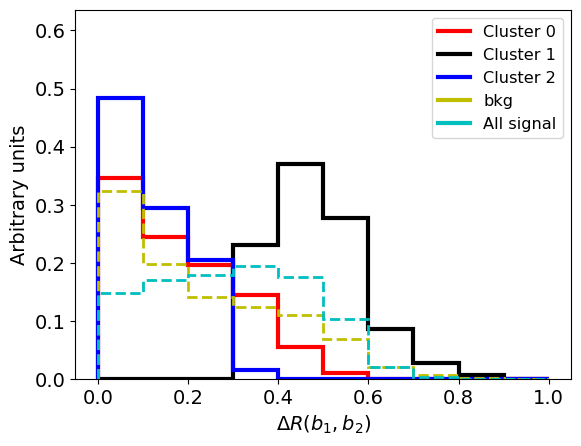

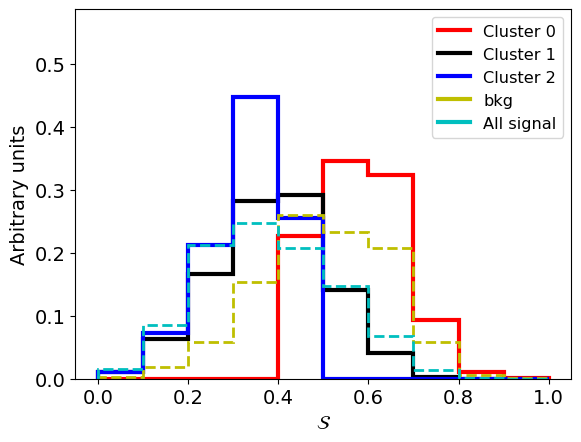

In [10]:
markers = ['s', 'P', 'o']
sampColors = ['r','b', 'k']
clusColors = ['r','k', 'b', 'g', 'y', 'c', 'm']
legHandles = []
for clusI in range(bestNClus):
    legHandles.append(matplotlib.lines.Line2D([], [], c=clusColors[clusI], linewidth=3))
legHandles.append(matplotlib.lines.Line2D([], [], c='y', linewidth=3))
legHandles.append(matplotlib.lines.Line2D([], [], c='c', linewidth=3))
# for sampColor in sampColors:
#     legHandles.append(matplotlib.lines.Line2D([], [], c=sampColor, linestyle='dashed')) 
    
minFracOfTotal = 0.1
labels = []
bins = [0.1*i for i in range(11)]
bkgData = scaledData[rawDataPresel.sampName=='bkg']
allSigData = scaledData[rawDataPresel.sampName!='bkg']
for varName in trainBranches:
    fig, ax = plt.subplots()
    for clusI in range(bestNClus):
        clusData = clusteringData[clusLabels==clusI]
        # Don't bother with clusters that are poorly represented ()
        if clusData.shape[0]/clusteringData.shape[0] < minFracOfTotal:
            continue
        plt.hist(clusData[varName], bins=bins, histtype='step', weights=np.ones(clusData[varName].shape[0])/clusData[varName].shape[0], label=f"Cluster {clusI}", color=clusColors[clusI], linewidth=3)
        labels.append(f"Cluster {clusI}")
    
    plt.hist(bkgData[varName], bins=bins, histtype='step', weights=np.ones(bkgData[varName].shape[0])/bkgData[varName].shape[0], linestyle='dashed', color='y', linewidth=2, label='bkg')
    labels.append('bkg')
    plt.hist(allSigData[varName], bins=bins, histtype='step', weights=np.ones(allSigData[varName].shape[0])/allSigData[varName].shape[0], linestyle='dashed', color='c', linewidth=2, label='sig')
    labels.append('All signal')

    xlabel = varName
    if varName in varLabels:
        xlabel = varLabels[varName]
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Arbitrary units')
    ax.set_ylim(0, ax.get_ylim()[1]*1.25)
    ax.legend(ncol=1, handles=legHandles, labels=labels, fontsize='small')
    plt.savefig(f"{varName}_postclustering.svg",bbox_inches='tight')
    plt.savefig(f"{varName}_postclustering.pdf",bbox_inches='tight')

In [11]:
def calcSignif(sigYield, bkgYield, bkgRelUnc=0.25):
  return sigYield/math.sqrt(sigYield+bkgYield+(bkgRelUnc*bkgYield)**2)  

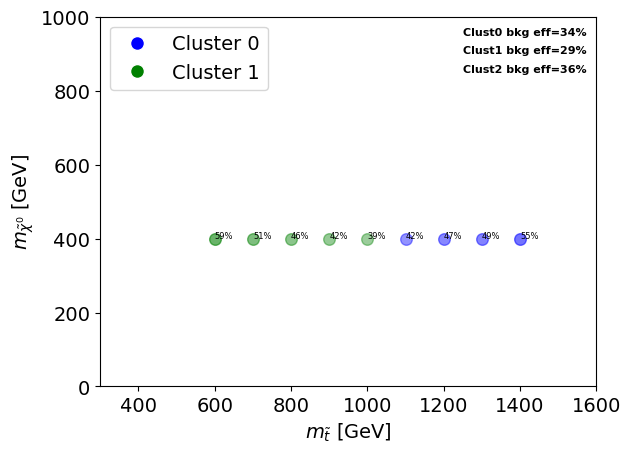

In [12]:
# Now let's plot where the clusters land on our simplified model grid
# Get the background efficiency and yields first
# We will pick the cluster with the best significance
bkgRelUnc = 0.25
bkgIndex = scaledData['sampName'] == 'bkg'
totalBkg = sum(bkgIndex*scaledData.weight)
bkgData = scaledData[bkgIndex]
bkgEffs = {}
bkgYields = {}
for clusI in range(bestNClus):
    clusIndex = (clusLabels==clusI) & (bkgIndex)
    bkgYield = np.sum(clusIndex*scaledData.weight)
    bkgYields[clusI] = bkgYield
    bkgEff = bkgYield/totalBkg
    bkgEffs[clusI] = bkgEff
    
stopMasses = []
lspMasses = []
sigBestEffs = []
bestSignifs = []
sigBestYields = []
sigBestClusLabels = []
for sampLabel in goodSamps:
    if 'bkg' in sampLabel:
        continue
    sigPointIndex = scaledData['sampName'] == sampLabel
    sigData = scaledData[sigPointIndex]
    totalSigYield = sum(sigPointIndex*scaledData.weight)

    if totalSigYield == 0:
        continue
    dummy, stopMass, lspMass = sampLabel.split("_")[:3]
    stopMass = int(stopMass)
    lspMass = int(lspMass)
    stopMasses.append(stopMass)
    lspMasses.append(lspMass)
    
    bestClus = -1
    bestSignif = -1
    bestYield = -1
    for clusI in range(bestNClus):
        clusIndex = (clusLabels==clusI) & (sigPointIndex)
        sigYield = sum(clusIndex*scaledData.weight)
        signif = calcSignif(sigYield, bkgYields[clusI], bkgRelUnc)
        if signif > bestSignif:
            bestSignif = signif
            bestClus = clusI
            bestYield = sigYield
    sigBestEffs.append(bestYield/totalSigYield)
    sigBestYields.append(bestYield)
    bestSignifs.append(bestSignif)
    sigBestClusLabels.append(bestClus)
fig, ax = plt.subplots()
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'lime']
for i in range(len(stopMasses)):
    plt.scatter([stopMasses[i]], [lspMasses[i]], c=colors[sigBestClusLabels[i]], label=f'Cluster {sigBestClusLabels[i]}', alpha=sigBestEffs[i], s=70)
    ax.annotate(f'{100*round(sigBestEffs[i], 2):.0f}%', (stopMasses[i], lspMasses[i]), fontsize=6)
ax.set_xlabel("$m_{\\tilde{t}}$ [GeV]")
ax.set_ylabel("$m_{\\tilde{\chi}^0}$ [GeV]")
ax.set_xlim(300,1600)
ax.set_ylim(0,1000)
for clusI in sorted(bkgEffs.keys()): 
    ax.annotate(f'Clust{clusI} bkg eff={int(round(bkgEffs[clusI]*100))}%', (1250, 950-clusI*50), fontsize=8, weight='bold')

handles, labels = plt.gca().get_legend_handles_labels()
sortedLabels = sorted(list(set(labels)))
handles = [matplotlib.lines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=colors[clusI], markersize=10) for clusI in range(bestNClus)]
#by_label = dict(zip(labels, handles))
plt.legend(handles=handles, labels=sortedLabels, loc='upper left')
plt.savefig(f"grid_postclustering_{varListStr}_eff.svg",bbox_inches='tight')
plt.savefig(f"grid_postclustering_{varListStr}_eff.pdf",bbox_inches='tight')

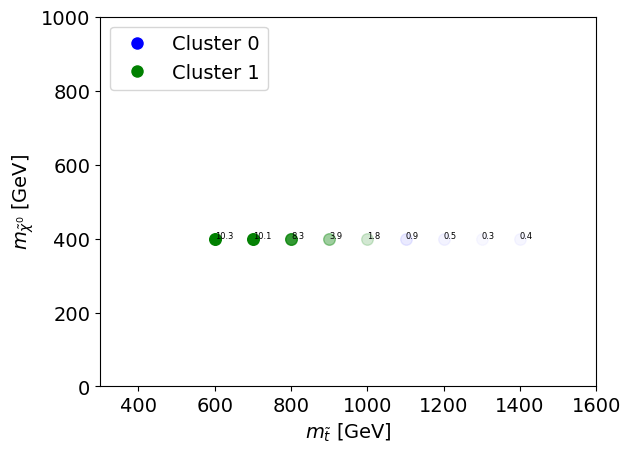

In [13]:
fig, ax = plt.subplots()
for i in range(len(stopMasses)):
    plt.scatter([stopMasses[i]], [lspMasses[i]], c=colors[sigBestClusLabels[i]], label=f'Cluster {sigBestClusLabels[i]}', alpha=bestSignifs[i]/max(bestSignifs), s=70)
    ax.annotate(f'{round(bestSignifs[i],1)}', (stopMasses[i], lspMasses[i]), fontsize=6)
ax.set_xlabel("$m_{\\tilde{t}}$ [GeV]")
ax.set_ylabel("$m_{\\tilde{\chi}^0}$ [GeV]")
ax.set_xlim(300,1600)
ax.set_ylim(0,1000)
plt.legend(handles=handles, labels=sortedLabels, loc='upper left')
plt.savefig(f"grid_postclustering_{varListStr}_signif.svg",bbox_inches='tight')
plt.savefig(f"grid_postclustering_{varListStr}_signif.pdf",bbox_inches='tight')

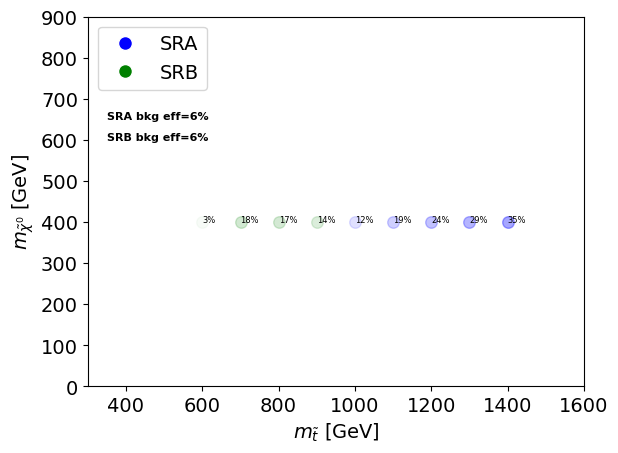

In [14]:
# Let's now see how the signal efficiency looks for SRA/B/C
srList = ['SRA', 'SRB']#, 'SRC1_5']
splitPat = '[><=]'
srReqStrs = {}
srColors = {}
for srI, sr in enumerate(srList):
    srReqStrs[sr] = re.sub('\(([a-zA-Z]+)', r'(sigData.\1', selections[sr].replace('*', ' & ').replace('||', ' | '))
    srColors[sr] = colors[srI]
#Now get the background efficiency
bkgIndex = rawDataPresel['sampName'] == 'bkg'
bkgData = rawDataPresel[bkgIndex]
totalBkg = sum(bkgIndex*rawDataPresel.weight)

bkgYields = {}
bkgEffs = {}
for sr in sorted(srList):
    srReqIndex = eval(srReqStrs[sr].replace('sigData', 'bkgData'))
    srYield = sum(srReqIndex*bkgData.weight)
    bkgYields[sr] = srYield
    srEff = srYield/totalBkg
    bkgEffs[sr] = srEff
    
sigBestEffs = []
bestSignifs = []
sigBestYields = []
bestSRs = []
for sampLabel in goodSamps:
    if 'bkg' in sampLabel:
        continue
    sigPointIndex = rawDataPresel['sampName'] == sampLabel
    totalSigYield = sum(sigPointIndex*rawDataPresel.weight)
    if totalSigYield == 0:
        continue
    sigData = rawDataPresel[sigPointIndex]
    bestSignif = -1
    bestSR = -1
    bestYield = -1
    bestEff = -1
    for sr in srReqStrs.keys():
        srReqIndex = eval(srReqStrs[sr])
        srYield = sum(srReqIndex*sigData.weight)
        srEff = srYield/totalSigYield
        signif = calcSignif(srYield, bkgYields[sr], bkgRelUnc)
        if signif > bestSignif:
            bestEff = srEff
            bestSignif = signif
            bestSR = sr
            bestYield = srYield
    sigBestEffs.append(round(bestEff,2))
    sigBestYields.append(bestYield)
    bestSRs.append(bestSR)
    bestSignifs.append(bestSignif)
fig, ax = plt.subplots()
for i in range(len(stopMasses)):
    plt.scatter([stopMasses[i]], [lspMasses[i]], c=srColors[bestSRs[i]], label=f'{bestSRs[i]}', alpha=sigBestEffs[i], s=70)
    ax.annotate(f'{100*round(sigBestEffs[i],2):.0f}%', (stopMasses[i], lspMasses[i]), fontsize=6)#, weight='bold')
for srI, sr in enumerate(bkgEffs.keys()):
    ax.annotate(f'{sr} bkg eff={int(round(bkgEffs[sr]*100))}%', (350, 650-srI*50), fontsize=8, weight='bold')

ax.set_xlabel("$m_{\\tilde{t}}$ [GeV]")
ax.set_ylabel("$m_{\\tilde{\chi}^0}$ [GeV]")
minStopMass = 300
ax.set_xlim(minStopMass,1600)
ax.set_ylim(0,900)
handles, labels = plt.gca().get_legend_handles_labels()
sortedLabels = sorted(list(set(labels)))
handles = [matplotlib.lines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=colors[srI], markersize=10) for srI in range(len(srList))]
plt.legend(handles=handles, labels=sortedLabels,  loc='upper left')
plt.savefig(f"grid_bestSR_eff.svg",bbox_inches='tight')
plt.savefig(f"grid_bestSR_eff.pdf",bbox_inches='tight')


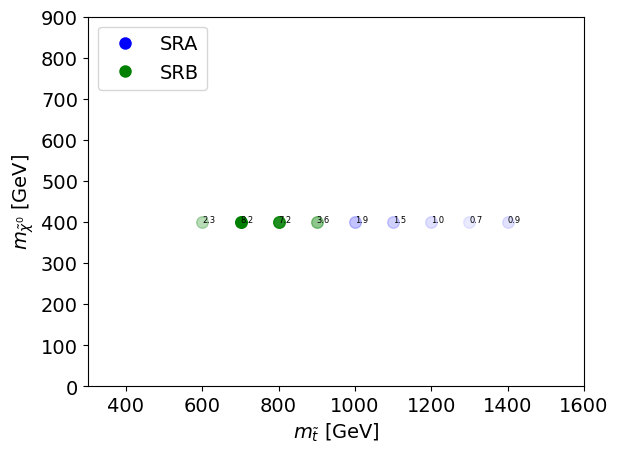

In [15]:
# Now let's get the significance
fig, ax = plt.subplots()
for i in range(len(stopMasses)):
    plt.scatter([stopMasses[i]], [lspMasses[i]], c=srColors[bestSRs[i]], label=f'{bestSRs[i]}', alpha=bestSignifs[i]/max(bestSignifs), s=70)
    ax.annotate(f'{round(bestSignifs[i],1)}', (stopMasses[i], lspMasses[i]), fontsize=6)#, weight='bold')
ax.set_xlabel("$m_{\\tilde{t}}$ [GeV]")
ax.set_ylabel("$m_{\\tilde{\chi}^0}$ [GeV]")
minStopMass = 300
ax.set_xlim(minStopMass,1600)
ax.set_ylim(0,900)
plt.legend(handles=handles, labels=sortedLabels,  loc='upper left')
plt.savefig(f"grid_bestSR_signif.svg",bbox_inches='tight')
plt.savefig(f"grid_bestSR_signif.pdf",bbox_inches='tight')